# Modeling Project Akhir Chatbot Info wisata Yogyakarta

## Import Library

In [3]:
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from keras.models import load_model
from tensorflow.keras.optimizers import legacy as keras_legacy

In [4]:
# Import file corpus untuk pre-prossesing

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("jogja.json").read()
intents = json.loads(data_file)

## Preprocessing data json

### Tokenization

Tokenization digunakan untuk membagi sampel besar teks atau kalimat menjadi kata-kata.

Tujuan dari tokenization adalah untuk mempersiapkan data teks untuk analisis lebih lanjut dengan mengubah teks yang tidak terstruktur menjadi daftar token yang terstruktur. 

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        # Tokenize untuk setiap kata
        w = nltk.word_tokenize(pattern)
        words.extend(w)

        # Menambah dokumen dalam corpus
        documents.append((w, intent['tag']))

        # Menambahkan ke daftar class
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Hasil tokenization 

print('Daftar Kata')
print(words)
print()
print('Daftar dokument')
print(documents)
print()
print('Daftar class')
print(classes)


Daftar Kata
['Halo', 'Hai', 'hay', 'halo', 'Halo', ',', 'Apa', 'kabar', '?', 'Hai', ',', 'Apa', 'kabar', '?', 'Thanks', 'Thank', 'you', 'Matur', 'nuwun', 'makasih', 'Terimakasih', 'qsqdq', 'dssdss', 'Apa', 'itu', 'JogjaInfoBot', '?', 'JogjaInfoBot', 'aplikasi', 'JogjaInfoBot', 'Sampai', 'jumpa', 'Goodbye', 'Bye', 'Selamat', 'tinggal', 'Informasi', 'tentang', 'Yogyakarta', 'Daerah', 'Istimewa', 'Yogyakarta', 'jogja', 'Tempat', 'wisata', 'dengan', 'rating', 'tertinggi', 'Wisata', 'dengan', 'rating', 'terbaik', 'di', 'Yogyakarta', 'Tempat', 'wisata', 'terpopuler', 'di', 'Jogja', 'Rating', 'Berdasarkan', 'Rating', 'Destinasi', 'dengan', 'harga', '0', 'rupiah', 'gratis', 'di', 'Yogyakarta', 'Tempat', 'tanpa', 'biaya', 'di', 'Jogja', 'bebas', 'biaya', 'masuk', 'Tidak', 'dipungut', 'biaya', 'populer', 'di', 'jogja', 'rekomendasi', 'yogyakarta', 'Tempat', 'paling', 'populer', 'Populer', 'wisata', 'Candi', 'Prambanan', 'Candi', 'Prambanan', 'Yogyakarta', 'Sejarah', 'Candi', 'Prambanan', 'Destin

### Lemmatization

Lemmatization adalah proses mengubah kata ke bentuk dasarnya (lemma) dengan menghapus infleksi kata seperti awalan, akhiran, dan imbuhan sehingga menghasilkan kata dasar yang lebih baku dan terstandardisasi.

Tujuan dari lemmatization adalah untuk membuat perbandingan kata-kata menjadi lebih mudah dan akurat, serta menghindari duplikasi kata yang berbeda bentuk.

In [7]:
# Merubah kata menjadi huruf kecil semua dan menghapus kata double (duplikat)

lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# sort classes
classes = sorted(list(set(classes)))

# Banyak Dokumen (pattern dan intents)
print('Jumlah Dokumen')
print(len(documents), 'Dokumen Yaitu ', documents)
print()

# Banyak kelas (intents)
print('Jumlah kelas')
print(len(classes), 'kelas Yaitu ', classes)
print()

# Banyak kata unik 
print('Jumlah kata unik')
print(len(words), 'Kata Unik Yaitu', words)

# Membuat file pickle
pickle.dump(words,open('words.pkl','wb')) 
pickle.dump(classes,open('classes.pkl','wb'))


Jumlah Dokumen
157 Dokumen Yaitu  [(['Halo'], 'salam'), (['Hai'], 'salam'), (['hay'], 'salam'), (['halo'], 'salam'), (['Halo', ',', 'Apa', 'kabar', '?'], 'salam'), (['Hai', ',', 'Apa', 'kabar', '?'], 'salam'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['Matur', 'nuwun'], 'thanks'), (['makasih'], 'thanks'), (['Terimakasih'], 'thanks'), (['qsqdq'], 'broken'), (['dssdss'], 'broken'), (['Apa', 'itu', 'JogjaInfoBot', '?'], 'JogjaInfoBot'), (['JogjaInfoBot'], 'JogjaInfoBot'), (['aplikasi', 'JogjaInfoBot'], 'JogjaInfoBot'), (['Sampai', 'jumpa'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Bye'], 'goodbye'), (['Selamat', 'tinggal'], 'goodbye'), (['Informasi', 'tentang', 'Yogyakarta'], 'informasi'), (['Daerah', 'Istimewa', 'Yogyakarta'], 'informasi'), (['jogja'], 'informasi'), (['Tempat', 'wisata', 'dengan', 'rating', 'tertinggi'], 'tempat_rating_tertinggi'), (['Wisata', 'dengan', 'rating', 'terbaik', 'di', 'Yogyakarta'], 'tempat_rating_tertinggi'), (['Tempat', 'wisata', 'terpopuler',

# Training Data

In [8]:
# Inisialisasi data Training
training = []

# Buat array kosong untuk output
output_empty = [0] * len(classes)

# Training set, bag of word untuk setiap kalimat
for doc in documents:
    # Inisialisasi bagg  of words
    bag =[]
    # mengambil token-token (kata-kata) dari suatu dokumen 
    pattern_words = doc[0]
    # melakukan lemmatization pada setiap kata 
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    #  membuat "bag of words" dari suatu dokumen yang direpresentasikan dalam variabel "pattern_words"
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    #  menentukan output atau label dari dokumen
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

# melakukan pengacakan urutan data dalam list "training" dengan menggunakan fungsi "random.shuffle"
random.shuffle(training)
training = np.array(training)

# Membuat list training dan testing
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


# Membuat Model
Membuat Model menggunakan Artificial Neural Network (ANN) dengan tipe Sequential. Pada model ini menggunakan satu input layer, satu hidden layer, output layer, dan dua dropout layer. Dimana pada layer pertama dan kedua menggunakan Relu dan layer terakhir menggunakan softmax.

In [9]:
# Membuat Sequential Neural Network Model untuk memprediksi respon
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19712     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 38)                2470      
                                                                 
Total params: 30,438
Trainable params: 30,438
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile model menggunakan optimizer Stochastic Gradient Descent (SGD) dengan Nesterov Accelerated Gradient.
sgd = keras_legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [11]:
# Fitting dan save model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot.h5', hist)
print('\n', '-'*20)
print('\nModel Berhasil dibuat!')


Epoch 1/200
32/32 [==============================] - 1s 2ms/step - loss: 3.6650 - accuracy: 0.0127
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 3.5858 - accuracy: 0.0637
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 3.5348 - accuracy: 0.0892
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 3.5325 - accuracy: 0.0637
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 3.4394 - accuracy: 0.1401
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 3.3291 - accuracy: 0.1975
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 3.2587 - accuracy: 0.1911
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 3.1088 - accuracy: 0.2166
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 2.9951 - accuracy: 0.2548
Epoch 10/200
32/32 [==============================] - 0s 2ms/step - loss: 2.8346 - accuracy: 0.3248
Epoch 11/

In [12]:
# Evaluasi hasil model
loss, accuracy = model.evaluate(train_x, train_y)
print(f"Loss: {loss}, Accuracy: {accuracy}")


5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - accuracy: 0.9936
Loss: 0.00934774149209261, Accuracy: 0.993630588054657


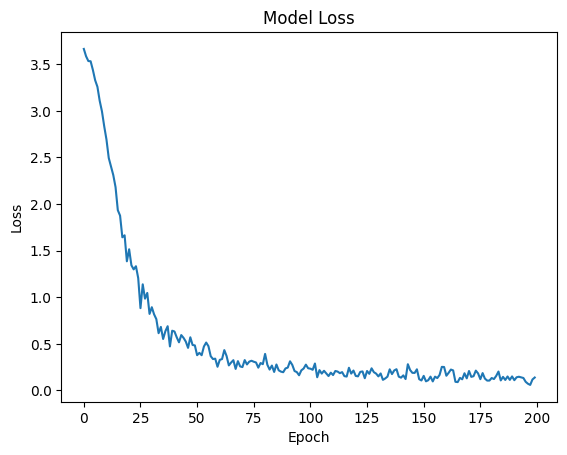

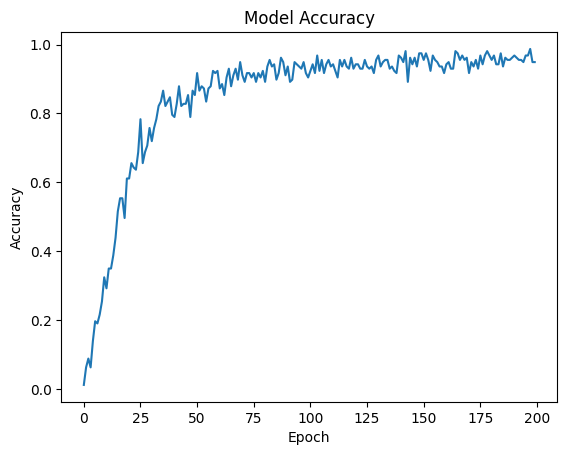

In [13]:
import matplotlib.pyplot as plt

# Plot riwayat loss
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot riwayat akurasi
plt.plot(hist.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


# Membuat fungsi input chat, pra-proses input, prediksi kelas, dan respons chat

In [14]:
# Meload data model, intents, words dan classes  
model = load_model('chatbot.h5')
intents = json.loads(open("jogja.json").read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [15]:
#  Clean up kalimat atau input pengguna
def clean_up_sentence(sentence):
    # tokenisasi kalimat menjadi kata-kata
    sentence_words = nltk.word_tokenize(sentence)

    # stemming atau mengubah kata menjadi bentuk dasarnya
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

In [16]:
# mengembalikan array bag of words dengan nilai 0 atau 1 untuk setiap kata dalam daftar kata (words) yang ada dalam kalimat (sentence).
def bow(sentence, words, show_details=True):
    # memanggil fungsi clean_up_sentence() untuk membersihkan kalimat.
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabuLary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

In [17]:

# Memprediksi intent atau tujuan dari suatu kalimat atau input. 
def predict_class(sentence, model):
    # Melakukan filter terhadap hasil prediksi yang probabilitasnya di bawah suatu threshold 
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    error = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>error]
    
    # Mengurutkan berdasarkan nilai probabilitas
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [18]:
# Fungsi get untuk mendapatkan respon dari model

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

# Fungsi untuk memprediksi kelas dan mendapatkan respon

def chatbot_response(text):
    try:
        ints = predict_class(text, model)
        res = getResponse(ints, intents)
    except:
        res = "Mas Joko : Maaf, saya tidak dapat memahami permintaan Anda. Mungkin Anda dapat mencoba menanyakan pertanyaan yang lebih spesifik atau menggunakan kata kunci yang berbeda untuk membantu saya memahami permintaan Anda dengan lebih baik."
    return res


In [19]:
# untuk memulai bot obrolan yang akan berlanjut hingga pengguna mengetik 'end'

def start_chat():
    print("Hai perkenalkan nama saya Mas Joko. \nsaya bisa membantu anda untuk informasi tentang informasi yang ada di Yogyakarta. \n\n")
    while True:
        inp = str(input()).lower()
        if 'end' in inp.lower():
            print("Mas Joko : Terima kasih telah menggunakan layanan kami. Sampai jumpa lagi!")
            break
        if inp.lower()== '' or inp.lower()== '*':
            print('Mas Joko : Anda belum tanya, ajukan pertanyaan dulu lah!')
            print("-"*50)
        else:
            print(f"Mas Joko : {chatbot_response(inp)}"+'\n')
            print("-"*50)

# Memulai Chatbot

In [20]:
# start_chat()